# Bayesian black-box model-predictive control

An Expected Free Energy minimizing agent based on a nonlinear autoregressive model with exogenous input.

## System: driven damped pendulum

Consider a single pendulum with angle $\theta(t)$ and input $u(t)$ evolving according to:

$$ \ddot{\theta} + \frac{\mathcal{g}}{l} \sin(\theta) + \frac{\gamma}{l} \dot{\theta} = \frac{1}{ml} u\, .$$

where $m$ is mass, $l$ is length, $\gamma$ is damping and $\mathcal{g}$ is Earth's gravity.

In [1]:
using Revise
using ForwardDiff
using Optim
using RxInfer
using SpecialFunctions
using LinearAlgebra
using ProgressMeter
using Distributions
using Plots; default(grid=false, label="", linewidth=3,margin=20Plots.pt)

includet("../NARXAgents.jl"); using .NARXAgents
includet("../Pendulums.jl"); using .Pendulums

In [2]:
# System parameters
sys_mass = 2.0
sys_length = 0.5
sys_damping = 0.2
sys_mnoise_sd = 1e-3
sys_ulims = (-50.,50.)
Δt = 0.1

init_state = [0.0, 0.0]
pendulum = SPendulum(init_state = init_state, 
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     torque_lims = sys_ulims,
                     Δt=Δt)

SPendulum([0.0, 0.0], -0.0006296936481212067, 0.0, (-50.0, 50.0), 0.1, 2.0, 0.5, 0.2, 0.001)

In [3]:
N = 300
tsteps = range(0.0, step=Δt, length=N)

0.0:0.1:29.9

In [4]:
# Inputs
A  = rand(10)*300 .- 100
Ω  = rand(10)*3
controls = mean([A[i]*sin.(Ω[i].*tsteps) for i = 1:10]) ./ 10;

In [5]:
states = zeros(2,N)
observations = zeros(N)
torques = zeros(N)

for k in 1:N
    states[:,k] = pendulum.state
    observations[k] = pendulum.sensor
    step!(pendulum, controls[k])
    torques[k] = pendulum.torque
end

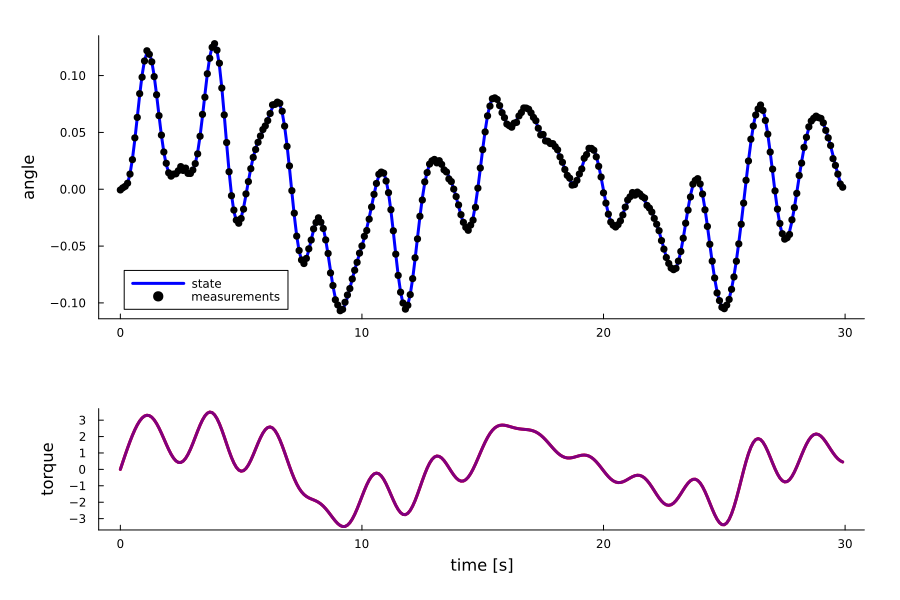

In [6]:
p1 = plot(ylabel="angle")
plot!(tsteps, states[1,:], color="blue", label="state")
scatter!(tsteps, observations, color="black", label="measurements")
p2 = plot(xlabel="time [s]", ylabel="torque")
plot!(tsteps, controls[:], color="red")
plot!(tsteps, torques[:], color="purple")
plot(p1,p2, layout=grid(2,1, heights=[0.7, 0.3]), size=(900,600))

## Test model

In [7]:
# NARX settings
H = 2
Ly = 5
Lu = 5
M = size(pol(zeros(Ly+Lu+1), degree=H),1);

# Specify prior distributions
α0 = 10.0
β0 = 1.0
μ0 = zeros(M)
Λ0 = 1e-2diagm(ones(M))
goal = NormalMeanVariance(0.5, 10.0)

T = 15

agent = NARXAgent(μ0, Λ0, α0, β0,
                  goal_prior=goal, 
                  delay_inp=Lu, 
                  delay_out=Ly, 
                  pol_degree=H,
                  time_horizon=T)

NARXAgent([0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 5, 5, 2, 23, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.01 0.0 … 0.0 0.0; 0.0 0.01 … 0.0 0.0; … ; 0.0 0.0 … 0.01 0.0; 0.0 0.0 … 0.0 0.01], 10.0, 1.0, 0.0, NormalMeanVariance{Float64}(μ=0.5, v=10.0), 15, 10, Inf)

In [8]:
py = []
μ = [μ0]
Λ = [Λ0]
α = [α0]
β = [β0]
FE = zeros(N)

torques_ = [torques; zeros(T)]
@showprogress for k in 1:N
    
    # Make predictions
    push!(py, predictions(agent, torques_[k:k+T], time_horizon=T))
    
    # Update beliefs
    NARXAgents.update!(agent, observations[k], torques[k])
    push!( μ, agent.μ )
    push!( Λ, agent.Λ )
    push!( α, agent.α )
    push!( β, agent.β )
    FE[k] = agent.free_energy
    
end

Progress:   1%|▎                                        |  ETA: 0:02:53

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


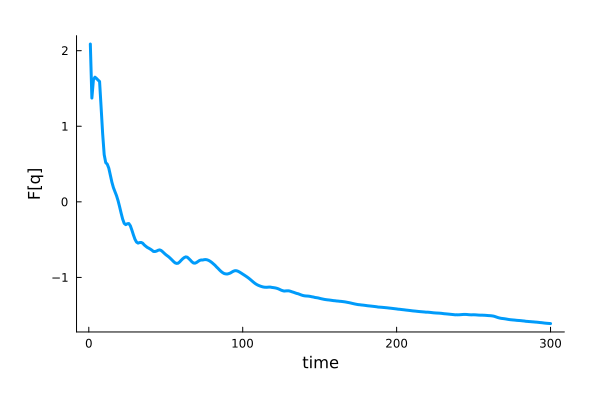

In [9]:
plot(FE, xlabel="time", ylabel="F[q]")

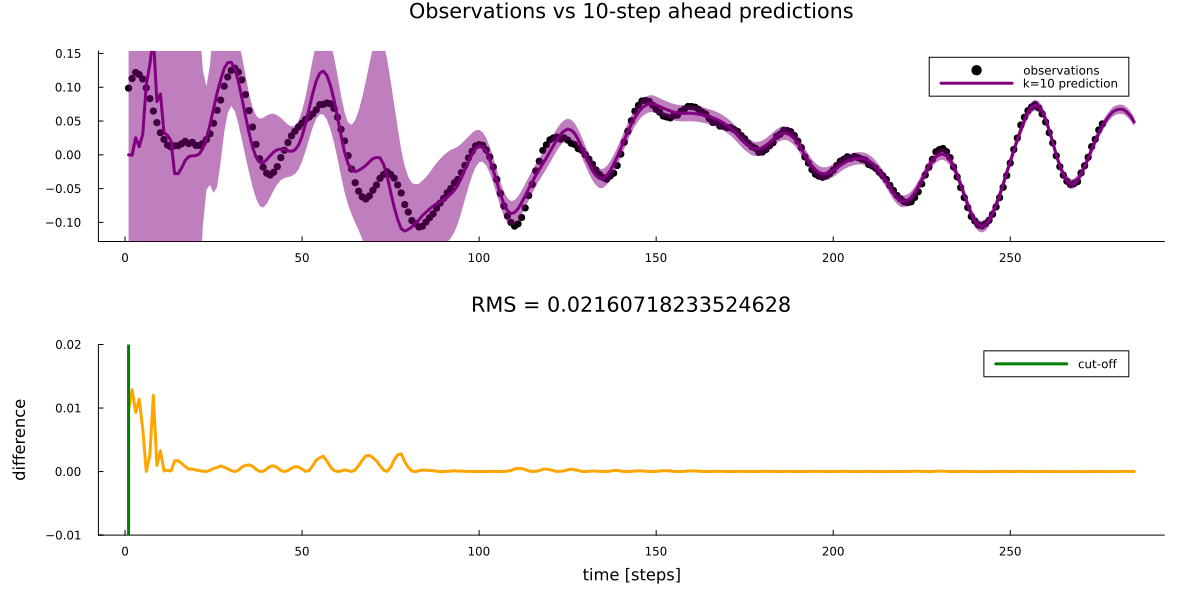

In [10]:
limsb = [minimum(observations)*1.2, maximum(observations)*1.2]
K = 10

residuals = (observations[K:K+(N-T)-1] .- [py[k][1][K] for k in 1:(N-T)]).^2
cutoff = 1
RMS = sqrt(mean((residuals[cutoff:end])))

p1 = plot(title="Observations vs $K-step ahead predictions", ylims=limsb)
scatter!(observations[K:N-T], color="black", label="observations")
plot!([py[k][1][K] for k in 1:(N-T)], ribbon=[py[k][2][K] for k in 1:(N-T)], color="purple", label="k=$K prediction")
p2 = plot(xlabel="time [steps]", ylims=(-0.01, 0.02))
plot!(residuals, title="RMS = $RMS", color="orange", ylabel="difference")
vline!([cutoff], color="green", label="cut-off")
plot(p1,p2,layout=grid(2,1), size=(1200,600),)

## Experiments

In [11]:
# Experiment specification 
N = 100
tsteps = range(0.0, step=Δt, length=N)
T = 15

# System specification
init_state = [0.0, 0.0];

# Agent specification
α0 = 10.0
β0 = 1.0
μ0 = zeros(M)
Λ0 = diagm(ones(M))
λ = 0.0

0.0

### Expected Free Energy minimization

In [20]:
# Start system
pendulum = SPendulum(init_state = init_state, 
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     torque_lims = sys_ulims,
                     Δt=Δt)

goals = [NormalMeanVariance(3.14, 1.0) for t in 1:T]
cut_gvar = tsteps[30]
new_gvar = 1e-2 
# gvars = [1e3 for k in 1:N]

# Start agent
agent = NARXAgent(μ0, Λ0, α0, β0,
                  goal_prior=goals, 
                  delay_inp=Lu, 
                  delay_out=Ly, 
                  pol_degree=H,
                  time_horizon=T)

# Preallocate
y_EFE = zeros(N)
z_EFE = zeros(2,N)
u_EFE = zeros(N+T)
μ_EFE = [μ0]
Λ_EFE = [Λ0]
α_EFE = [α0]
β_EFE = [β0]
F_EFE = zeros(N)
pred_m = zeros(N,T)
pred_v = zeros(N,T)

@showprogress for k in 1:N    
    
    # Update parameter beliefs
    y_EFE[k] = pendulum.sensor
    NARXAgents.update!(agent, y_EFE[k], u_EFE[k])
    F_EFE[k] = agent.free_energy
    push!(μ_EFE, agent.μ )
    push!(Λ_EFE, agent.Λ )
    push!(α_EFE, agent.α )
    push!(β_EFE, agent.β )

    # Change exploration-exploitation balance
    if k > cut_gvar; agent.goals = [NormalMeanVariance(3.14, new_gvar) for t in 1:T]; end
    # goal_k = NormalMeanVariance(3.14, gvars[k])
    # update_goals!(goals, goal_k)
    # agent.goals = goals
    
    # Optimal control
    policy = minimizeEFE(agent, goals, control_lims=sys_ulims)
    u_EFE[k+1:k+T] = policy
    
    # Store future predictions
    pred_m[k,:], pred_v[k,:] = predictions(agent, policy, time_horizon=T)

    # Act upon environment
    step!(pendulum, u_EFE[k+1])
    z_EFE[:,k] = pendulum.state
    
end

Progress:   2%|▉                                        |  ETA: 0:06:10

Progress:   3%|█▎                                       |  ETA: 0:04:13

Progress:   4%|█▋                                       |  ETA: 0:03:16

Progress:   5%|██                                       |  ETA: 0:02:40

Progress:   6%|██▌                                      |  ETA: 0:02:15

Progress:   7%|██▉                                      |  ETA: 0:01:57

Progress:   8%|███▎                                     |  ETA: 0:01:43

Progress:   9%|███▊                                     |  ETA: 0:01:33

Progress:  10%|████▏                                    |  ETA: 0:01:24

Progress:  11%|████▌                                    |  ETA: 0:01:18

Progress:  12%|████▉                                    |  ETA: 0:01:12

Progress:  13%|█████▍                                   |  ETA: 0:01:08

Progress:  14%|█████▊                                   |  ETA: 0:01:05

Progress:  15%|██████▏                                  |  ETA: 0:01:04

Progress:  16%|██████▌                                  |  ETA: 0:01:03

Progress:  17%|███████                                  |  ETA: 0:01:02

Progress:  18%|███████▍                                 |  ETA: 0:01:02

Progress:  19%|███████▊                                 |  ETA: 0:01:01

Progress:  20%|████████▎                                |  ETA: 0:01:00

Progress:  21%|████████▋                                |  ETA: 0:00:59

Progress:  22%|█████████                                |  ETA: 0:00:58

Progress:  23%|█████████▍                               |  ETA: 0:00:57

Progress:  24%|█████████▉                               |  ETA: 0:00:55

Progress:  25%|██████████▎                              |  ETA: 0:00:53

Progress:  26%|██████████▋                              |  ETA: 0:00:51

Progress:  27%|███████████▏                             |  ETA: 0:00:50

Progress:  28%|███████████▌                             |  ETA: 0:00:48

Progress:  29%|███████████▉                             |  ETA: 0:00:47

Progress:  30%|████████████▎                            |  ETA: 0:00:46

Progress:  31%|████████████▊                            |  ETA: 0:00:45

Progress:  32%|█████████████▏                           |  ETA: 0:00:44

Progress:  33%|█████████████▌                           |  ETA: 0:00:42

Progress:  34%|██████████████                           |  ETA: 0:00:41

Progress:  35%|██████████████▍                          |  ETA: 0:00:40

Progress:  36%|██████████████▊                          |  ETA: 0:00:40

Progress:  37%|███████████████▏                         |  ETA: 0:00:39

Progress:  38%|███████████████▋                         |  ETA: 0:00:39

Progress:  39%|████████████████                         |  ETA: 0:00:39

Progress:  40%|████████████████▍                        |  ETA: 0:00:39

Progress:  41%|████████████████▊                        |  ETA: 0:00:40

Progress:  42%|█████████████████▎                       |  ETA: 0:00:41

Progress:  43%|█████████████████▋                       |  ETA: 0:00:42

Progress:  44%|██████████████████                       |  ETA: 0:00:44

Progress: 100%|█████████████████████████████████████████| Time: -1:-57:-24


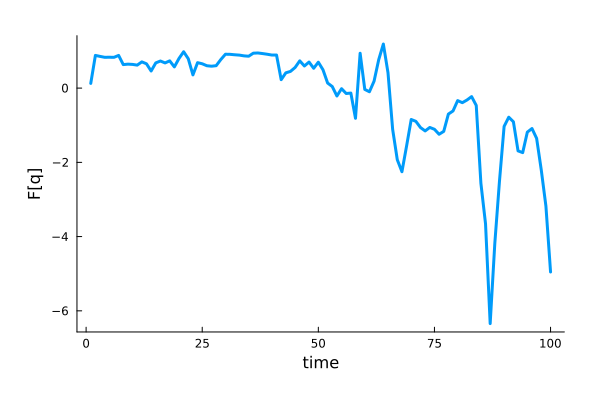

In [21]:
plot(F_EFE, xlabel="time", ylabel="F[q]")

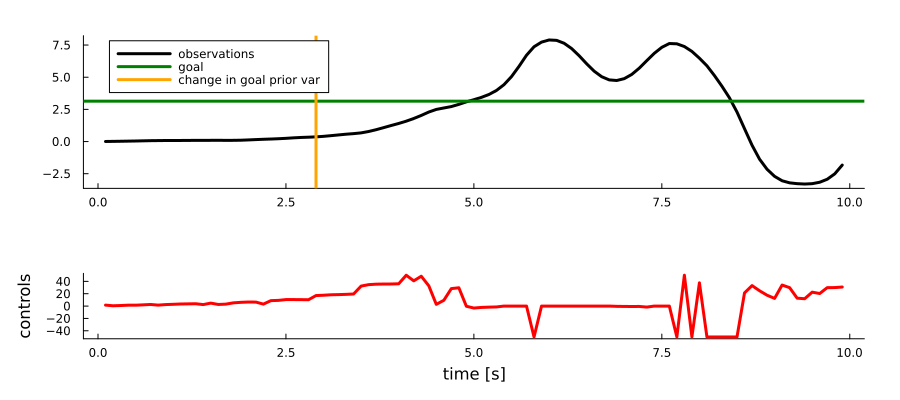

In [22]:
p1 = plot(tsteps[2:end], y_EFE[2:end], color="black", label="observations")
hline!([mean(goals[1])], color="green", label="goal")
vline!([cut_gvar], color="orange", label="change in goal prior var")
p4 = plot(tsteps[2:end], u_EFE[2:end-T], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

In [23]:
savefig("figures/NARX-EFE-1Pendulum-trial.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/notebooks/figures/NARX-EFE-1Pendulum-trial.png"

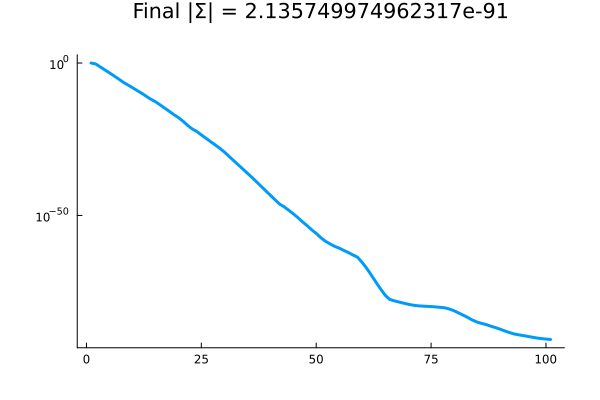

In [24]:
dSθ_EFE = det.(inv.(Λ_EFE))
final_dSθ_EFE = dSθ_EFE[end]
plot(dSθ_EFE, title="Final |Σ| = $final_dSθ_EFE", yscale=:log10)

┌ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/notebooks/figures/NARX-EFE-1Pendulum-planning.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/notebooks/figures/NARX-EFE-1Pendulum-planning.gif")
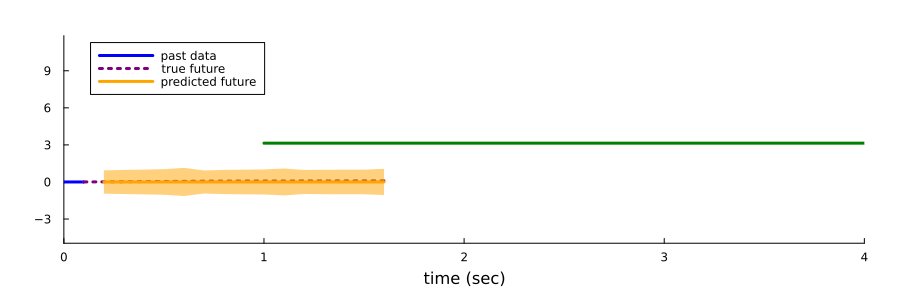

In [25]:
limsb = [minimum(y_EFE)*1.5, maximum(y_EFE)*1.5]

window = 20

anim = @animate for k in 2:2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_EFE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="predicted future", color="orange", legend=:topleft)
        plot!(mean.(goals), color="green")
    else
        plot(tsteps[k-window:k], y_EFE[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="prediction", color="orange", legend=:topleft)
        plot!(mean.(goals), color="green")
    end
    
end
gif(anim, "figures/NARX-EFE-1Pendulum-planning.gif", fps=24)

### Mean Squared Error minimization

In [26]:
# Start system
pendulum = SPendulum(init_state = init_state, 
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     torque_lims = sys_ulims,
                     Δt=Δt)

# Start agent
agent = NARXAgent(μ0, Λ0, α0, β0,
                  goal_prior=goal, 
                  delay_inp=Lu, 
                  delay_out=Ly, 
                  pol_degree=H,
                  time_horizon=T)

# Preallocate
y_MSE = zeros(N)
z_MSE = zeros(2,N)
u_MSE = zeros(N+T)
μ_MSE = [μ0]
Λ_MSE = [Λ0]
α_MSE = [α0]
β_MSE = [β0]
F_MSE = zeros(N)
pred_m = zeros(N,T)
pred_v = zeros(N,T)
goals = [NormalMeanVariance(3.14, Inf) for t in 1:T]
gvars = 10 .^range(3, stop=-3, length=N)
# gvars = [1e3 for k in 1:N]

@showprogress for k in 1:N    
    
    # Update parameter beliefs
    y_MSE[k] = pendulum.sensor
    NARXAgents.update!(agent, y_MSE[k], u_MSE[k])
    F_MSE[k] = agent.free_energy
    push!(μ_MSE, agent.μ )
    push!(Λ_MSE, agent.Λ )
    push!(α_MSE, agent.α )
    push!(β_MSE, agent.β )

    # Move goal closer
    goal_k = NormalMeanVariance(3.14, gvars[k])
    update_goals!(goals, goal_k)
    agent.goals = goals
    
    # Optimal control
    policy = minimizeMSE(agent, goals, control_lims=sys_ulims)
    u_MSE[k+1:k+T] = policy
    
    # Store future predictions
    pred_m[k,:], pred_v[k,:] = predictions(agent, policy, time_horizon=T)

    # Act upon environment
    step!(pendulum, u_MSE[k+1])
    z_MSE[:,k] = pendulum.state
    
end

Progress:   2%|▉                                        |  ETA: 0:01:13

Progress:   4%|█▋                                       |  ETA: 0:00:45

Progress:   5%|██                                       |  ETA: 0:01:06

Progress:   6%|██▌                                      |  ETA: 0:01:03

Progress:   7%|██▉                                      |  ETA: 0:00:58

Progress:   8%|███▎                                     |  ETA: 0:00:55

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /home/wmkouw/.julia/packages/LineSearches/G1LRk/src/hagerzhang.jl:148


AssertionError: AssertionError: isfinite(phi_c) && isfinite(dphi_c)

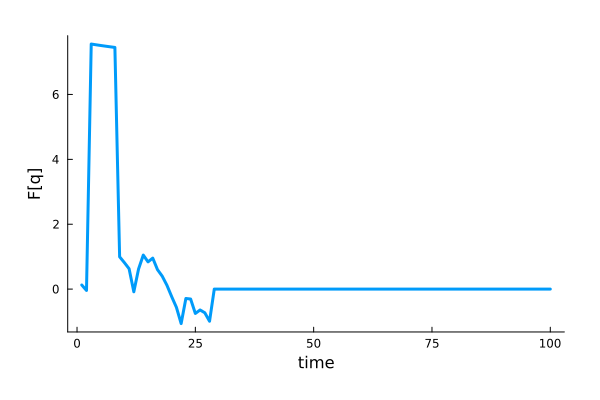

In [27]:
plot(F_MSE, xlabel="time", ylabel="F[q]")

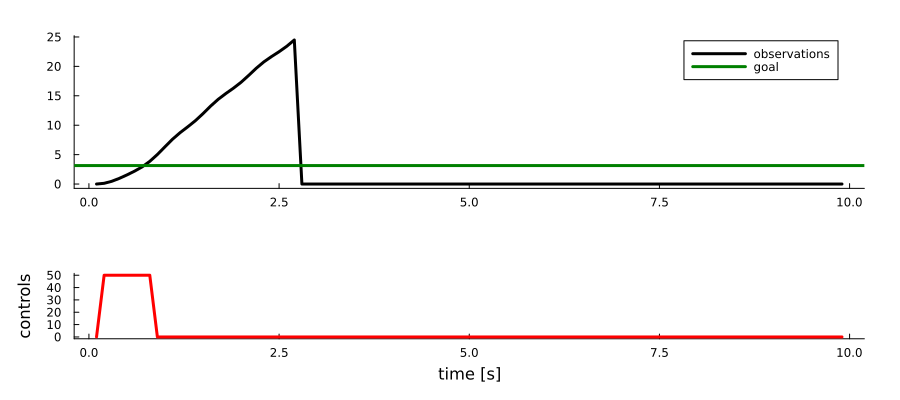

In [28]:
p1 = plot(tsteps[2:end], y_MSE[2:end], color="black", label="observations")
hline!([mean(goals[1])], color="green", label="goal")
p4 = plot(tsteps[2:end], u_MSE[2:end-T], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

In [29]:
savefig("figures/NARX-MSE-1Pendulum-trial.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/notebooks/figures/NARX-MSE-1Pendulum-trial.png"

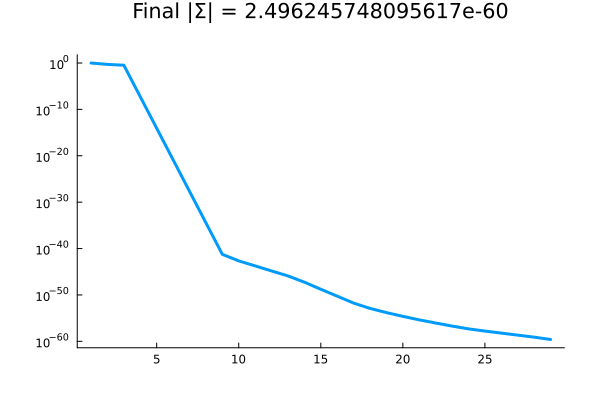

In [30]:
dSθ_MSE = det.(inv.(Λ_MSE))
final_dSθ_MSE = dSθ_MSE[end]
plot(dSθ_MSE, title="Final |Σ| = $final_dSθ_MSE", yscale=:log10)

┌ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/notebooks/figures/NARX-MSE-1Pendulum-planning.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/notebooks/figures/NARX-MSE-1Pendulum-planning.gif")
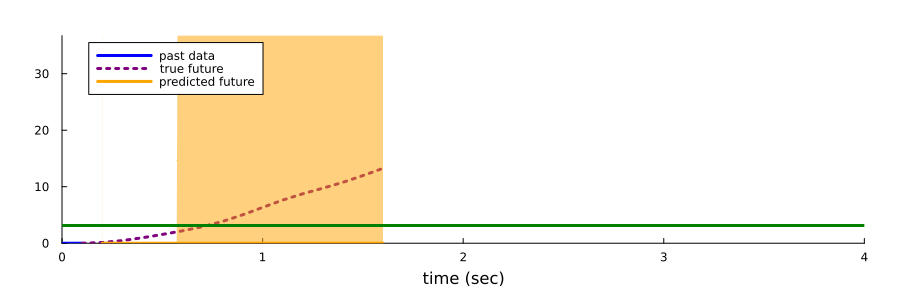

In [31]:
limsb = [minimum(y_MSE)*1.5, maximum(y_MSE)*1.5]

window = 20

anim = @animate for k in 2:2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_MSE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_MSE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="predicted future", color="orange", legend=:topleft)
        hline!([mean(goals[1])], color="green")
    else
        plot(tsteps[k-window:k], y_MSE[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_MSE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="prediction", color="orange", legend=:topleft)
        hline!([mean(goals[1])], color="green")
    end
    
end
gif(anim, "figures/NARX-MSE-1Pendulum-planning.gif", fps=24)

### Comparisons

In [32]:
println("Final sum of eigenvalues of Σ_θ for MSE = $final_dSθ_MSE")
println("Final sum of eigenvalues of Σ_θ for EFE = $final_dSθ_EFE")

Final sum of eigenvalues of Σ_θ for MSE = 2.496245748095617e-60
Final sum of eigenvalues of Σ_θ for EFE = 2.135749974962317e-91


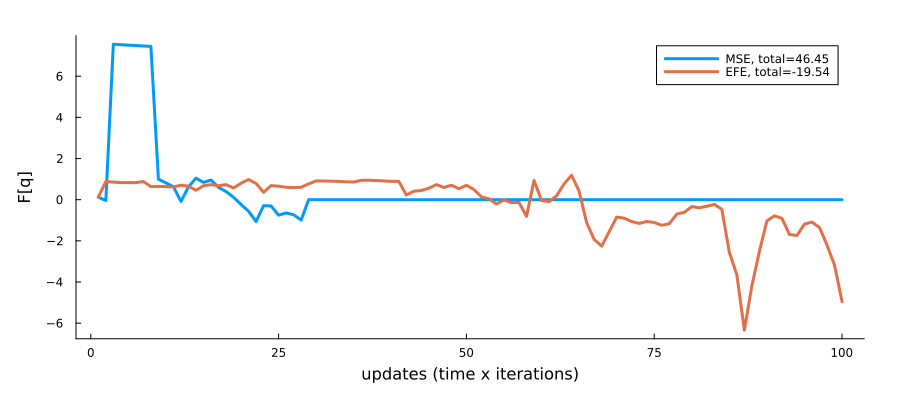

In [33]:
sF_MSE = round(sum(F_MSE[:]), digits=2)
sF_EFE = round(sum(F_EFE[:]), digits=2)

plot(xlabel="updates (time x iterations)", ylabel="F[q]", size=(900,400))
plot!(F_MSE[:], label="MSE, total=$sF_MSE")
plot!(F_EFE[:], label="EFE, total=$sF_EFE")

In [34]:
# evidence_MSE = [-logpdf(py_MSE[k][1], y_MSE[k+1]) for k in 1:(N-1)]
# evidence_EFE = [-logpdf(py_EFE[k][1], y_EFE[k+1]) for k in 1:(N-1)]

# total_evidence_MSE = round(sum(evidence_MSE), digits=2)
# total_evidence_EFE = round(sum(evidence_EFE), digits=2)

# plot(xlabel="time (steps)", ylabel="-logp(y)", size=(900,400))
# plot!(evidence_MSE, label="MSE, total=$total_evidence_MSE")
# plot!(evidence_EFE, label="EFE, total=$total_evidence_EFE")

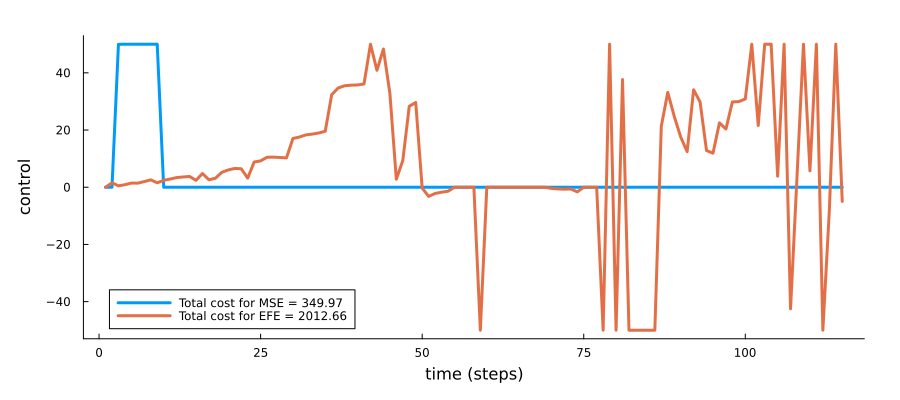

In [35]:
CC_MSE = round(sum(abs.(u_MSE)), digits=2)
CC_EFE = round(sum(abs.(u_EFE)), digits=2)

plot(xlabel="time (steps)", ylabel="control", size=(900,400))
plot!(u_MSE, label="Total cost for MSE = $CC_MSE")
plot!(u_EFE, label="Total cost for EFE = $CC_EFE")

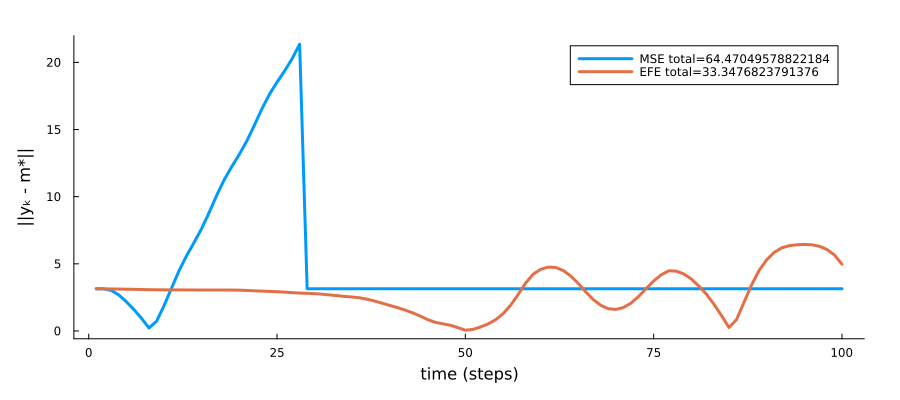

In [36]:
J_MSE = [norm(y_MSE[k] - mean(goals[1]),2) for k in 1:N]
J_EFE = [norm(y_EFE[k] - mean(goals[1]),2) for k in 1:N]

sJ_MSE = norm(y_MSE .- mean(goals[1]),2)
sJ_EFE = norm(y_EFE .- mean(goals[1]),2)

plot(xlabel="time (steps)", ylabel="||yₖ - m*||", size=(900,400))
plot!(J_MSE, label="MSE total=$sJ_MSE")
plot!(J_EFE, label="EFE total=$sJ_EFE")